# Анализ пиковой нагрузки на сервис такси

## Описание проекта

Компания «Чётенькое такси» предоставила исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Тип задачи:** регрессия

## Описание данных

* `num_orders` - (от англ. number of orders, «число заказов») количество заказов.

## Импорты и настройки

In [1]:
# Импорты
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import randint

In [2]:
# Настройки
pd.set_option('display.float_format', '{:.2f}'.format)

## План работы

* Загрузка данных и первоначальный осмотр
* Подготовка датасета и ресемплирование
* Анализ данных
* Обучение регрессионных моделей
* Проверка на тестовых данных
* Выводы

## Загрузка данных и первоначальный осмотр

Загрузка данных:

In [3]:
try:
    original_df = pd.read_csv('/datasets/taxi.csv')
    display('Данные из практикума загружены.')
except:
    original_df = pd.read_csv('datasets/taxi.csv')
    display('Локальные данные загружены.')

original_df.name = 'original_df'

'Локальные данные загружены.'

Первоначальный осмотр:

In [4]:
display('Размер датасета:', original_df.shape)
display('Голова:', original_df.head())
display('Хвост:', original_df.tail())
display('Информация:', original_df.info())

'Размер датасета:'

(26496, 2)

'Голова:'

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


'Хвост:'

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


'Информация:'

None

Проверим на наличие прямых дублей в данных:

In [5]:
original_df.duplicated().sum()

0

**Выводы:**
* Временной ряд из 26 тыс. строк.
* Требуется изменения типа данных в `datetime`.
* Пропуски отсутствуют, дублей нет.

## Подготовка датасета и ресемплирование

Необходимо привести `datetime` к формату datetime, установить этот столбец в качестве индекса, отсортировать по индексу и провести ресемплирование по часу:

In [6]:
# Создадим рабочую копию датасета.
df = original_df.copy()

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

# Проверка:
display(df.info())

df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

# Проверка:
display('Отсортировано по индексу', df.index.is_monotonic)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


None

'Отсортировано по индексу'

True

In [8]:
df_resampled_1h = df.resample('1H').sum()
display(df_resampled_1h.shape)

(4416, 1)

**Выводы:**
* Данные приведены в порядок.
* После почасового ресемплирования количество строк сократилось с 26 496 до 4 416.

## Анализ данных

Визуализируем ресемплированные данные:

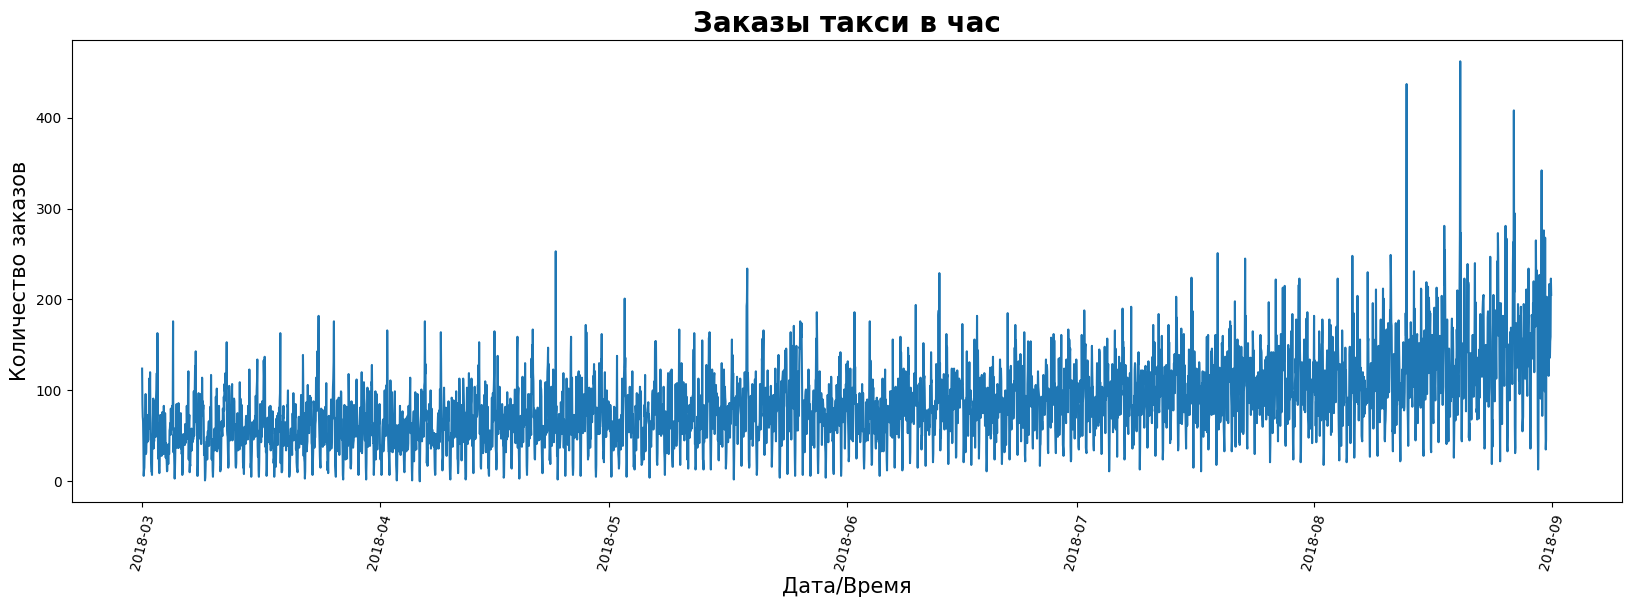

In [9]:
def plot_data(series):
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title('Заказы такси в час', fontsize=20, weight='bold')
    ax.set_xlabel('Дата/Время', fontsize=15)
    ax.set_ylabel('Количество заказов', fontsize=15)
    ax.tick_params(axis='x', labelsize=10, rotation=75)
    ax.tick_params(axis='y', labelsize=10)
    ax.plot(series)

plot_data(df_resampled_1h['num_orders'])

Взглянем на периоды пиковых нагрузок в августе:

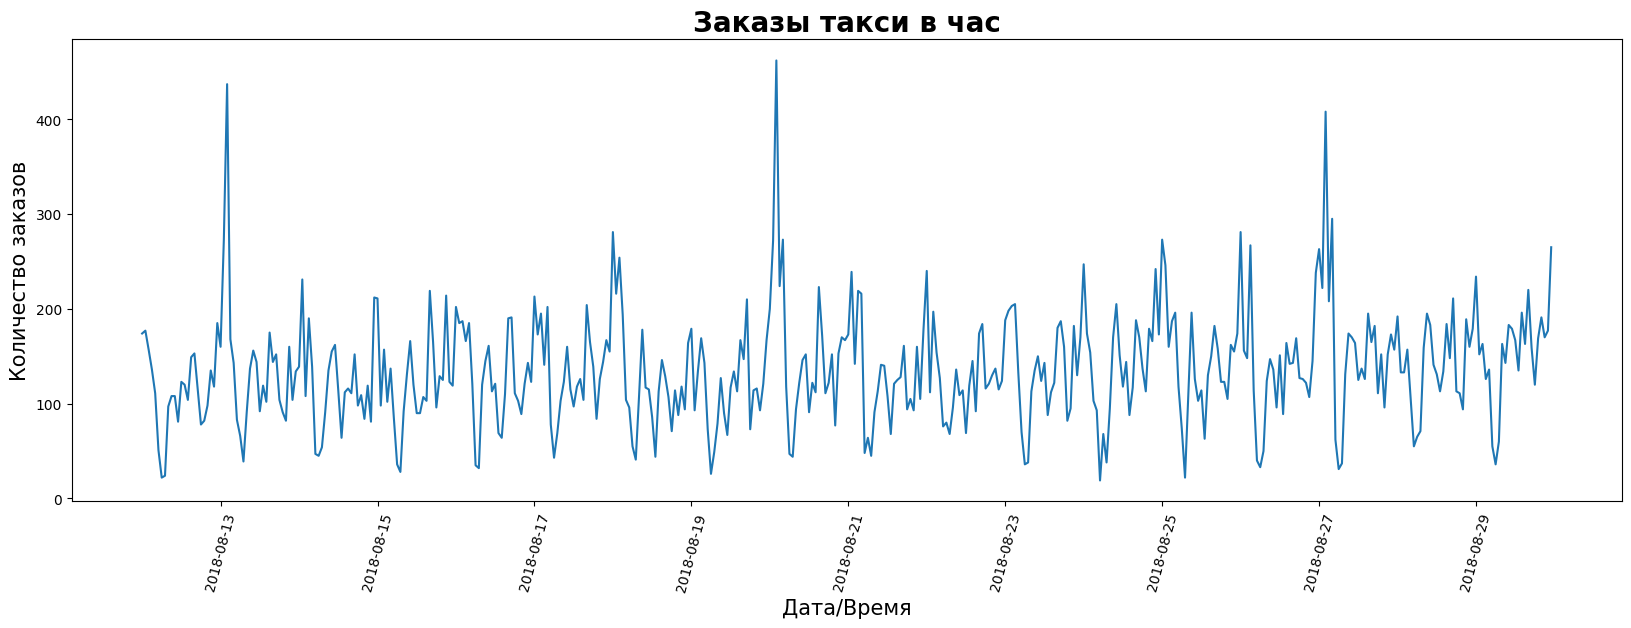

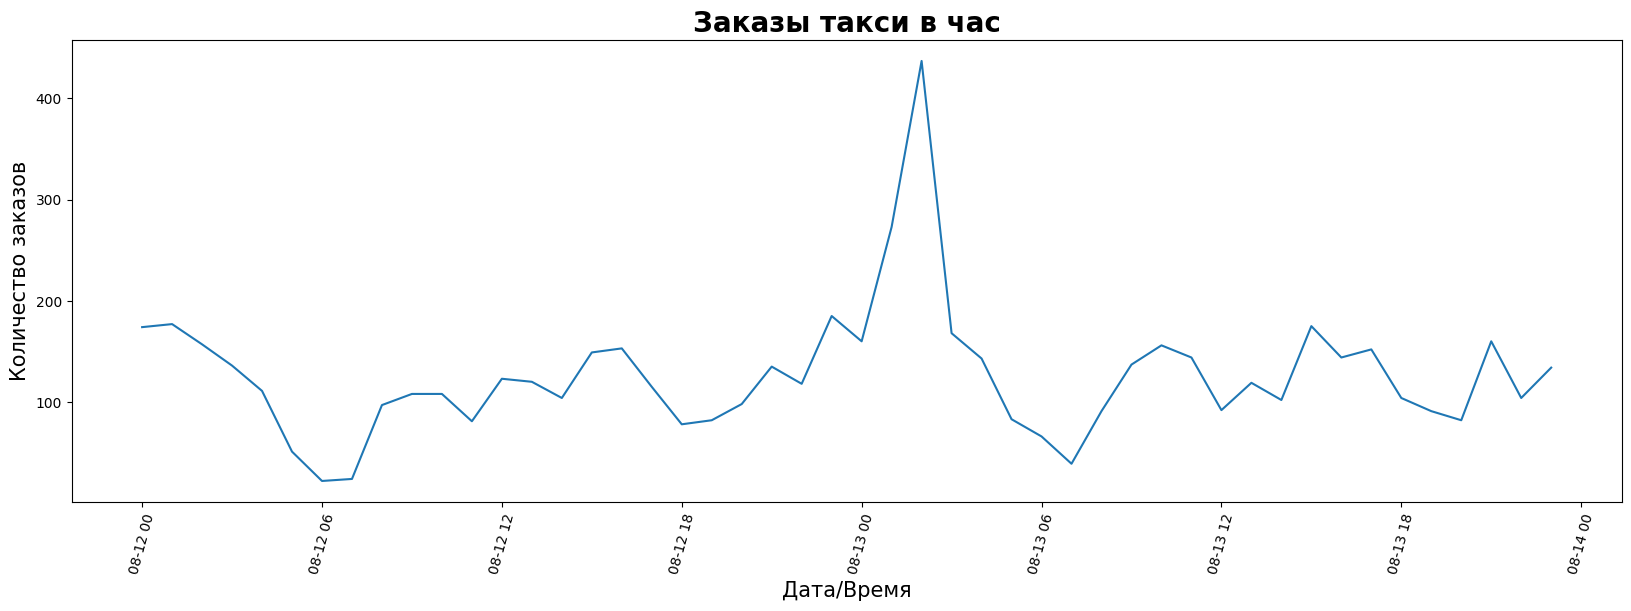

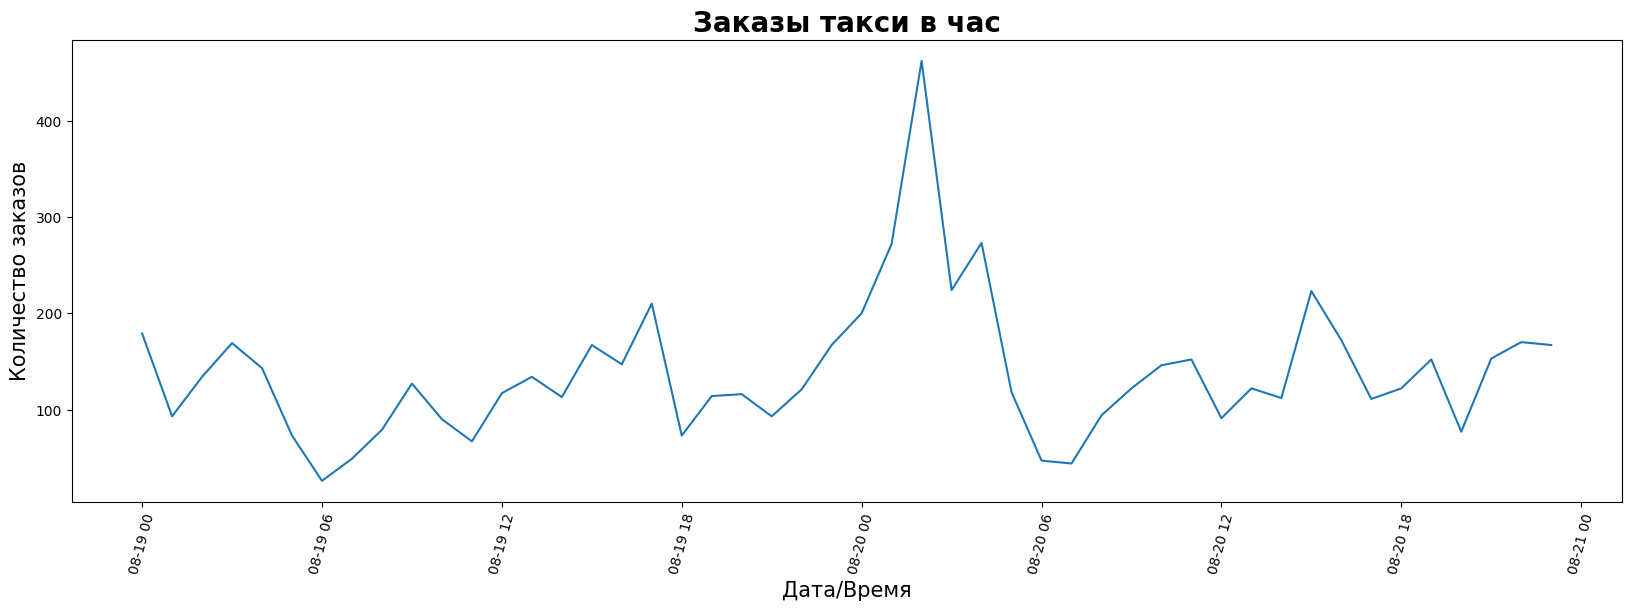

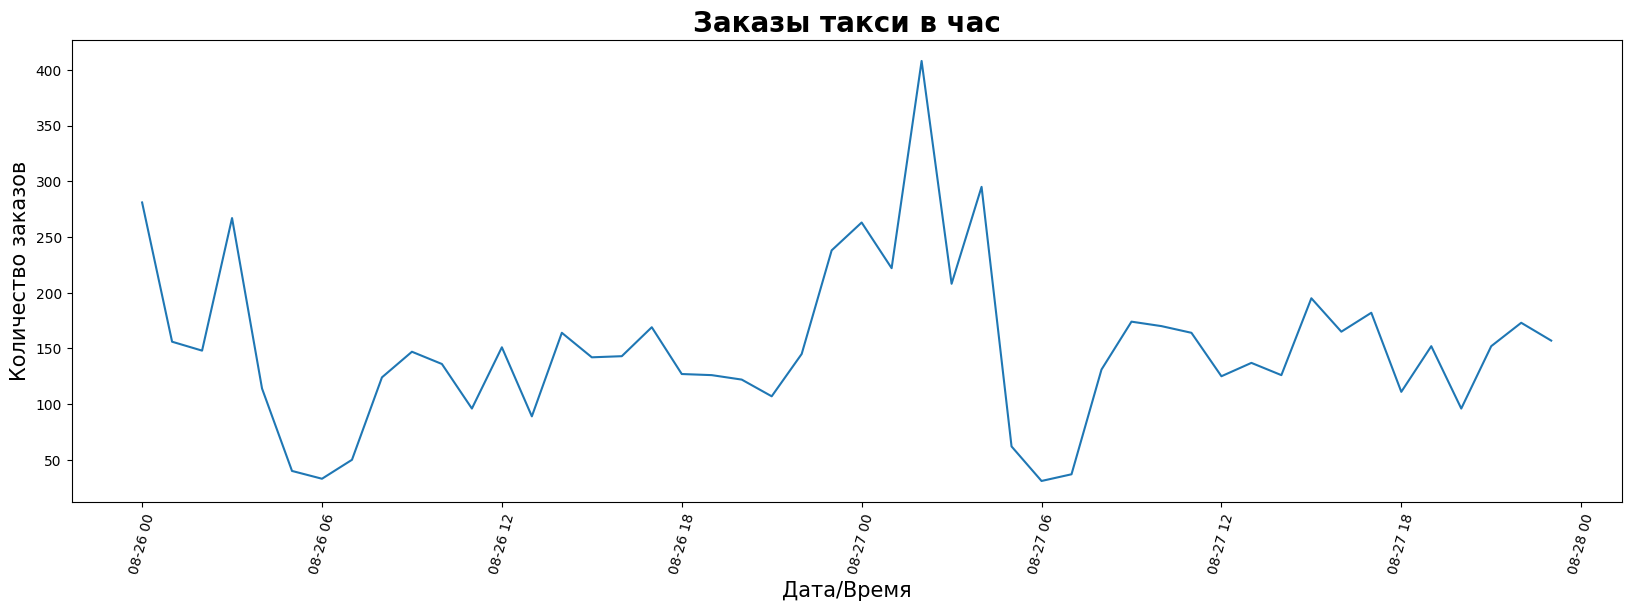

In [10]:
plot_data(df_resampled_1h['2018-08-12':'2018-08-29']['num_orders'])
plot_data(df_resampled_1h['2018-08-12':'2018-08-13']['num_orders'])
plot_data(df_resampled_1h['2018-08-19':'2018-08-20']['num_orders'])
plot_data(df_resampled_1h['2018-08-26':'2018-08-27']['num_orders'])

Все пики приходятся на ночь понедельника. Август - летний месяц, месяц отпусков. Вероятно такие нагрузки связаны с возвращением людей из отпусков точно к началу первого рабочего дня (чтобы не потерять ни одного дня отпуска).

Взглянем на пики в мае:

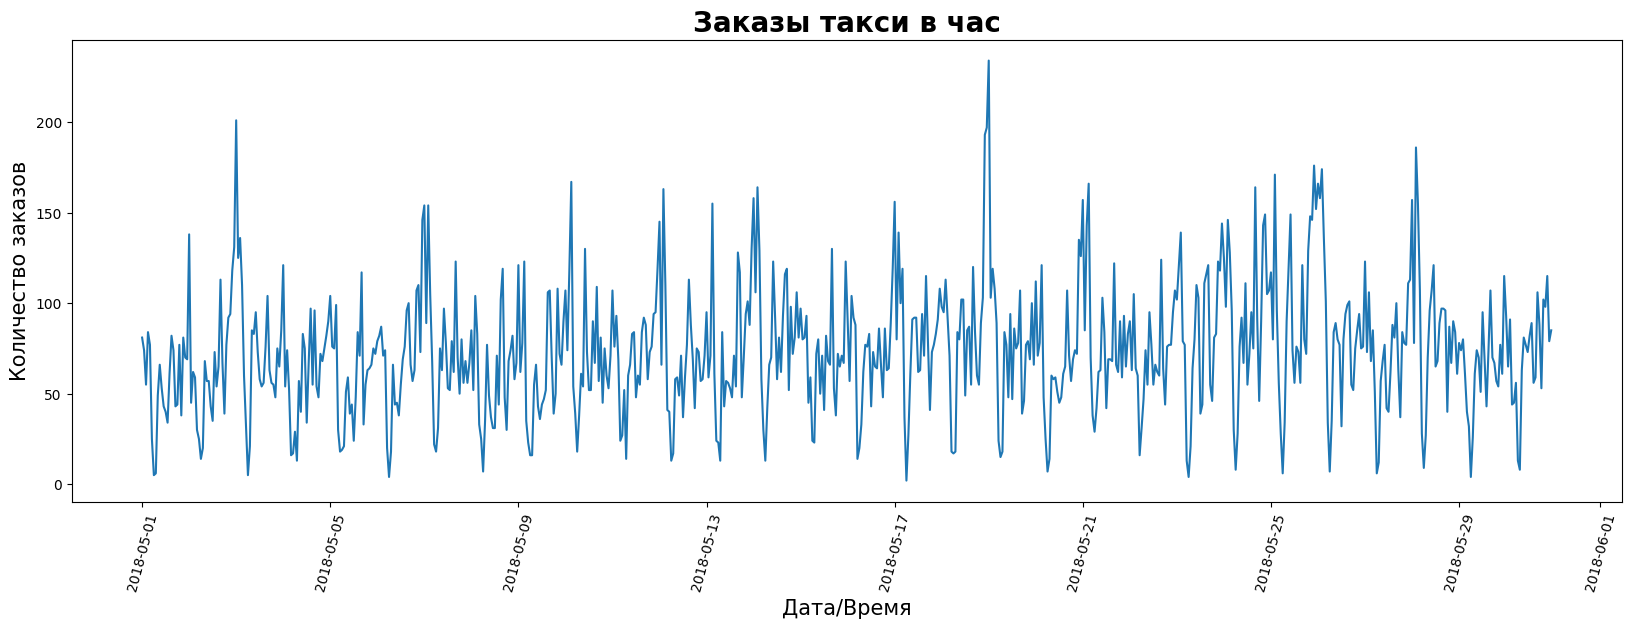

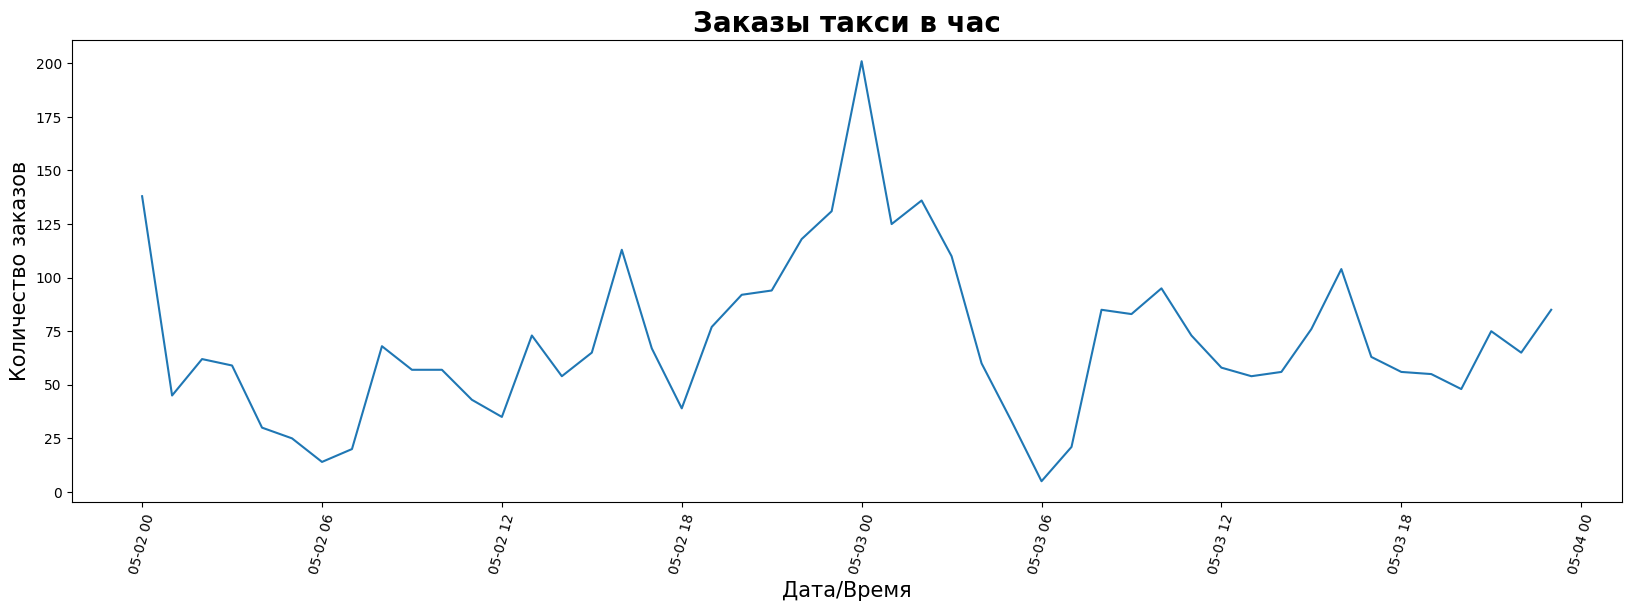

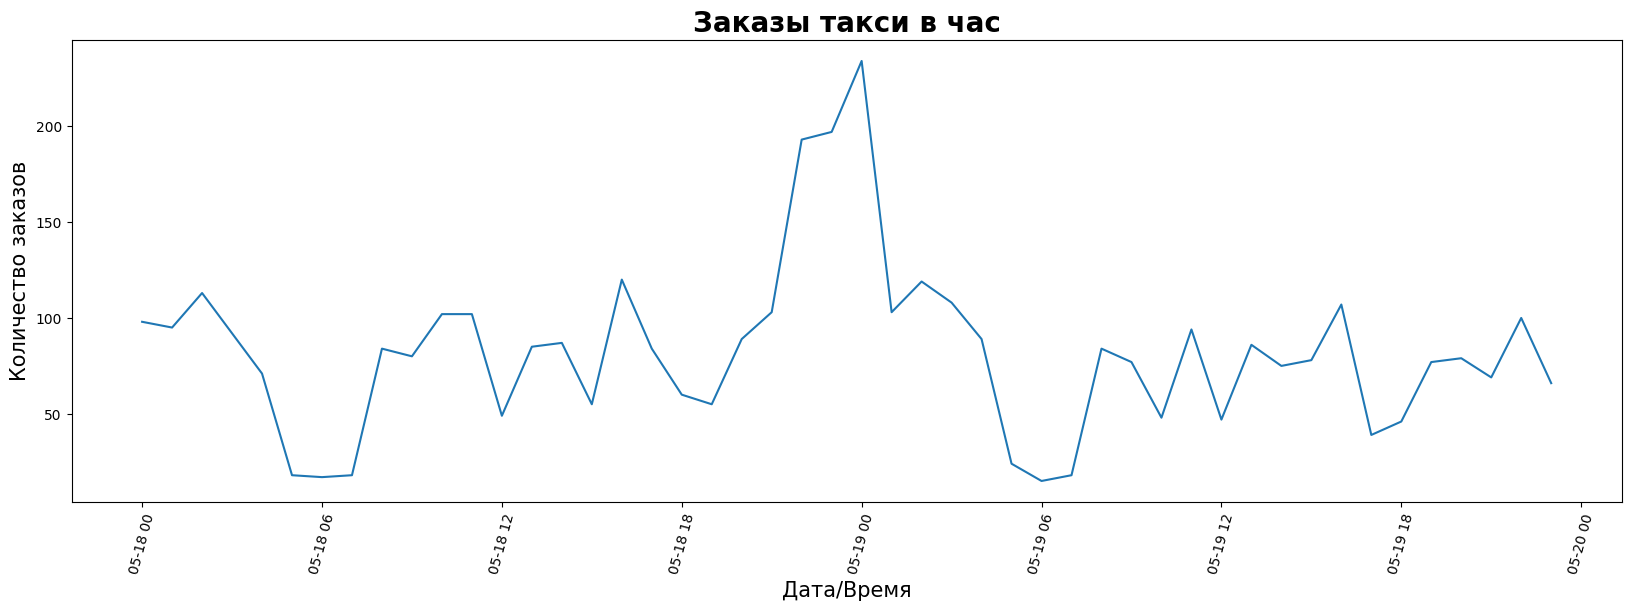

In [11]:
plot_data(df_resampled_1h['2018-05-01':'2018-05-30']['num_orders'])
plot_data(df_resampled_1h['2018-05-02':'2018-05-03']['num_orders'])
plot_data(df_resampled_1h['2018-05-18':'2018-05-19']['num_orders'])
# plot_data(df_resampled_1h['2018-08-26':'2018-08-27']['num_orders'])

Пики так же приходятся на ночное время, причина скорее всего аналогична - отпуска в праздничные дни. Пик 3 мая связан с окончанием майских праздников в 2018 году. Пик 19 числа объяснить сложнее, но скорее всего он связан с тем, что в эту дату подходит к концу период двухнедельных отпусков, которые люди брали сразу после майских праздников, чтобы максимизировать период отдыха.

Попробуем декомпозировать на тренды, сезонность и шум и визуализировать результаты:

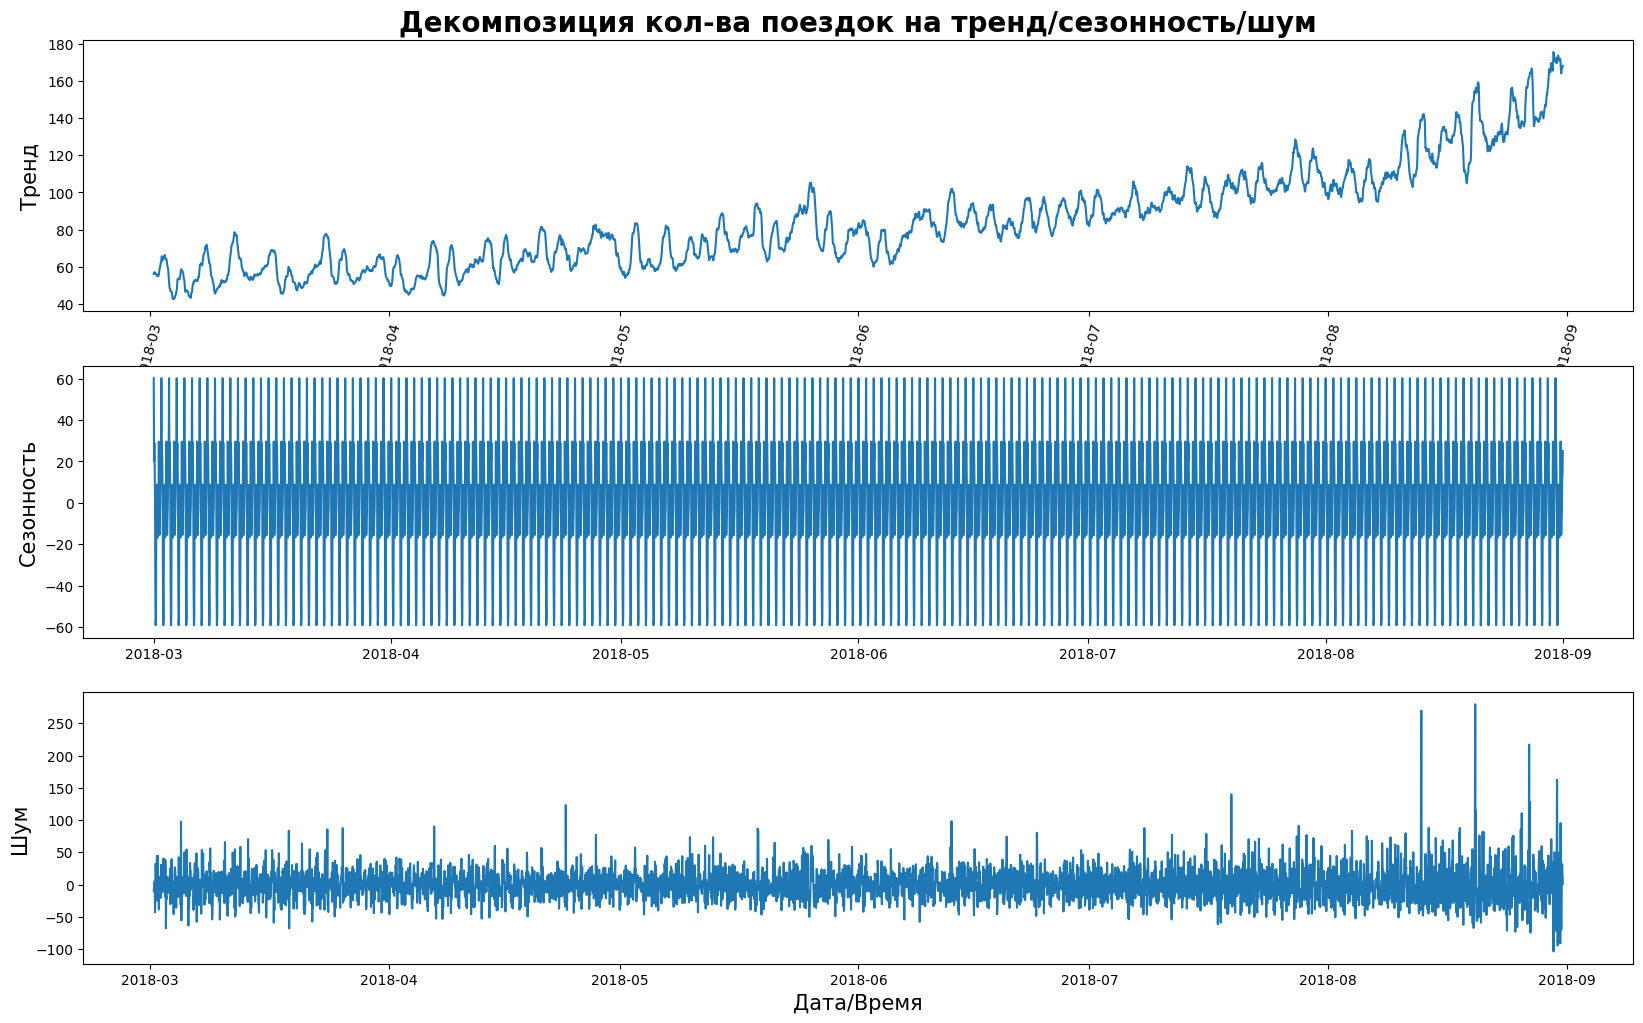

In [12]:
decomposed = seasonal_decompose(df_resampled_1h['num_orders'])
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
ax1.set_title('Декомпозиция кол-ва поездок на тренд/сезонность/шум', fontsize=20, weight='bold')
ax3.set_xlabel('Дата/Время', fontsize=15)
ax1.set_ylabel('Тренд', fontsize=15)
ax2.set_ylabel('Сезонность', fontsize=15)
ax3.set_ylabel('Шум', fontsize=15)
ax1.tick_params(axis='x', labelsize=10, rotation=75)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(decomposed.trend)
ax2.plot(decomposed.seasonal)
ax3.plot(decomposed.resid)

Тренд имеет явно восходящих характер. Шум так же в абсолютных значениях имеет тенденцию к росту (что не удивительно т.к. тренд восходящий и значения количества поездок растут). В шумовой составляющей так же можно увидеть пики, причины которых обсуждены выше.

Взглянем подробнее на сезонность в различных масштабах (месяц, неделя, сутки) на примере мая месяца:

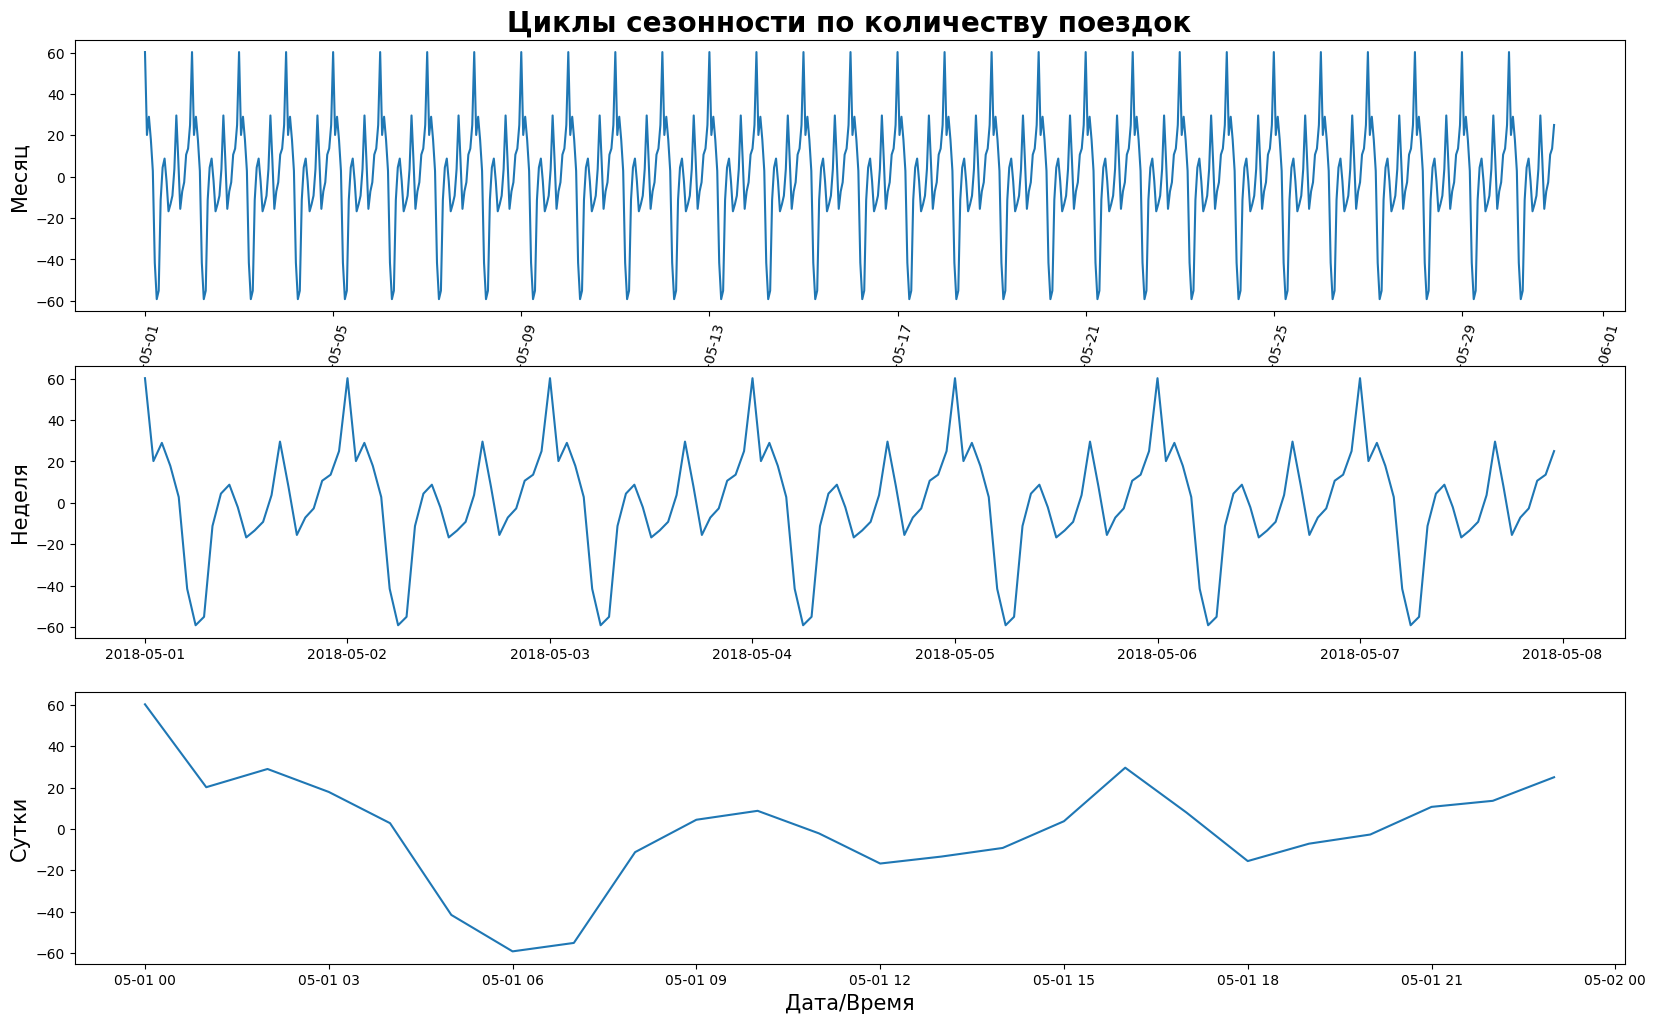

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
ax1.set_title('Циклы сезонности по количеству поездок', fontsize=20, weight='bold')
ax3.set_xlabel('Дата/Время', fontsize=15)
ax1.set_ylabel('Месяц', fontsize=15)
ax2.set_ylabel('Неделя', fontsize=15)
ax3.set_ylabel('Сутки', fontsize=15)
ax1.tick_params(axis='x', labelsize=10, rotation=75)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(decomposed.seasonal['2018-05-01':'2018-05-30'])
ax2.plot(decomposed.seasonal['2018-05-01':'2018-05-07'])
ax3.plot(decomposed.seasonal['2018-05-01':'2018-05-01'])

В целом сезонность имеет явно суточный характер с пиками в районе полуночи, начала и конца рабочего дня и провалом в районе 6 утра.

**Выводы:**
* В целом данные выглядят логично. Есть несколько значительных пиков, но они вполне объясняются периодами отпусков и производственным календарём.
* В данных можно явно видеть тренд на увеличение количества поездок за наблюдаемый период. Видимо это связано с ростом популярности и удобства сервиса такси в целом.
* Так же можно обратить внимание на то, что сезонность имеет суточный характер и пиковые нагрузки на такси приходятся в основном на ночное время. Скорее всего это связанто с тем, что общественный транспорт в этот период дня недоступен. Так же повышенный спрос приходится на время начала и окончания стандартного рабочего дня.

## Обучение регрессионных моделей

Перед обучением необходимо сгенерировать фичи. Напишем функцию, которая добавляет информацию о дне недели, дне месяца, месяце, скользящем среднем (недельном), тренде, сезонной составляющей, остатке, лагах.

In [14]:
# Вводные параметры
lag_number = 24
window_size = 7

In [15]:
def generate_features(df, lag_number, window_size):
    # Создадим копию датафрейма
    new_df = df.copy()

    # Добавим календарную информацию
    new_df['weekday'] = new_df.index.weekday
    new_df['month'] = new_df.index.month
    new_df['day'] = new_df.index.day

    # Добавим лаги
    for i in range(1, lag_number + 1):
        column_name = 'lag_' + str(i)
        new_df[column_name] = new_df['num_orders'].shift(i)

    # Добавим скользящее среднее
    new_df['rolling_mean'] = new_df['lag_1'].rolling(window_size).mean()

    # Добавим тренд, сезонную составляющую и остаток (добавим лаг, чтобы данные из будущего не учитывались при обучении).
    decomposed = seasonal_decompose(new_df['num_orders'])
    new_df['trend_decomp'] = decomposed.trend.shift(1)
    new_df['seasonal_decomp'] = decomposed.seasonal.shift(1)
    new_df['resid_decomp'] = decomposed.resid.shift(1)

    return new_df

df_resampled_1h_with_new_features = generate_features(df_resampled_1h,
                                                      lag_number=lag_number,
                                                      window_size=window_size)
df_resampled_1h_with_new_features.shape

(4416, 32)

Избавимся от na строк:

In [16]:
df_resampled_1h_with_new_features.dropna(inplace=True)
df_resampled_1h_with_new_features.shape

(4381, 32)

Выделим тренировочную и тестовую выборки:

In [17]:
train_data, test_data = train_test_split(df_resampled_1h_with_new_features, test_size=0.1, shuffle=False)
train_data.shape, test_data.shape

((3942, 32), (439, 32))

Выделим фичи и таргеты:

In [18]:
X_train = train_data.drop(columns='num_orders', axis='columns')
y_train = train_data['num_orders']
X_test = test_data.drop(columns='num_orders', axis='columns')
y_test = test_data['num_orders']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3942, 31), (3942,), (439, 31), (439,))

Т.к. между номером дня недели и количеством заказов нет прямой связи - закодируем этот столбец методом target encoding. Напишем для этого отдельный класс.

In [19]:
class TargetEncoder():
    def __init__(self):
        # Словарь словарей (название столбца > категория > значение).
        self.fit_dict = {}

    def fit(self, X, y):
        # Берем все object столбцы
        self.obj_columns = X.select_dtypes(include='object').columns
        # Объединяем фичи с таргетом
        X_and_y = pd.concat([X, y], axis='columns')
        for column in self.obj_columns:
            # Считаем для каждого столбца среднее по каждой категории
            mean_for_categories = X_and_y.groupby(column)['num_orders'].mean()
            # Заполняем словарь словарей
            self.fit_dict[column] = mean_for_categories.to_dict()

    def transform(self, X):
        result = X.copy()
        for column in self.obj_columns:
            # На случай, если категория новая и её не было на этапе fit - устанавливаем среднее значение по столбцу.
            for category in result[column].unique():
                if category not in self.fit_dict[column].keys():
                    mean_for_column = list(self.fit_dict[column].values()).mean()
                    result[column].replace(category, mean_for_column, inplace=True)
            # Для всех остальных значений делаем замену по словарю.
            result[column].replace(self.fit_dict[column], inplace=True)
        return result

    def get_fit_dict(self):
        return self.fit_dict

Переведем `weekday` в тип object, чтобы target_encoding сработал для этого столбца и сделаем сам target encoding.


In [20]:
X_train['weekday'] = X_train.astype('object')
X_test['weekday'] = X_test.astype('object')

target_encoder = TargetEncoder()
target_encoder.fit(X_train, y_train)
X_train = target_encoder.transform(X_train)
X_test = target_encoder.transform(X_test)

Данные готовы. Перейдем к обучению. Будем использовать 3 модели (LR, DTR, RFR).

In [21]:
%%time
# Для будущих результатов
results = []

model_1 = LinearRegression()
model_2 = DecisionTreeRegressor(random_state=777)
model_3 = RandomForestRegressor(random_state=777)

param_distribution_1 = {
                        }

param_distribution_2 = {
                        'model__max_depth': randint(5, 20),
                        }

param_distribution_3 = {
                        'model__max_depth': randint(5, 20),
                        'model__n_estimators': randint(5, 99)
                        }


# Объединим в лист для перебора
models_and_distrs = [('LR', model_1, param_distribution_1),
                     ('DTR', model_2, param_distribution_2),
                     ('RFR', model_3, param_distribution_3),
                     ]

# Запустим подбор лучших параметров
for model_name, model, param_distribution in models_and_distrs:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('model', model)])

    kf = TimeSeriesSplit(n_splits=4)
    cv = RandomizedSearchCV(estimator=pipe,
                            cv=kf,
                            scoring='neg_root_mean_squared_error',
                            param_distributions=param_distribution,
                            n_jobs=-1,
                            n_iter=20,
                            verbose=0,
                            random_state=777,
                            )

    cv.fit(X_train, y_train)

    # Индекс лучшей модели
    best_index = cv.cv_results_["mean_test_score"].argmax()
    display(f'Лучший результат для {model_name}: {cv.best_params_}, {-cv.best_score_:.2f}')
    display(f'Время обучения лучшей модели: {cv.cv_results_["mean_fit_time"][best_index]:.2f}')
    display(f'Время предсказания лучшей модели: {cv.cv_results_["mean_score_time"][best_index]:.2f}')

    # Добавление в результаты
    results.append((model_name,
                    cv.best_estimator_,
                    cv.best_params_,
                    -cv.best_score_,
                    cv.cv_results_["mean_fit_time"][best_index],
                    cv.cv_results_["mean_score_time"][best_index],
                   ))

C:\Users\denis\miniconda3\envs\Practicum\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


'Лучший результат для LR: {}, 24.82'

'Время обучения лучшей модели: 0.03'

'Время предсказания лучшей модели: 0.01'

"Лучший результат для DTR: {'model__max_depth': 5}, 30.37"

'Время обучения лучшей модели: 0.05'

'Время предсказания лучшей модели: 0.01'

"Лучший результат для RFR: {'model__max_depth': 17, 'model__n_estimators': 76}, 24.83"

'Время обучения лучшей модели: 3.66'

'Время предсказания лучшей модели: 0.03'

CPU times: total: 6.84 s
Wall time: 1min 16s


Визуализируем итоговые результаты по моделям:

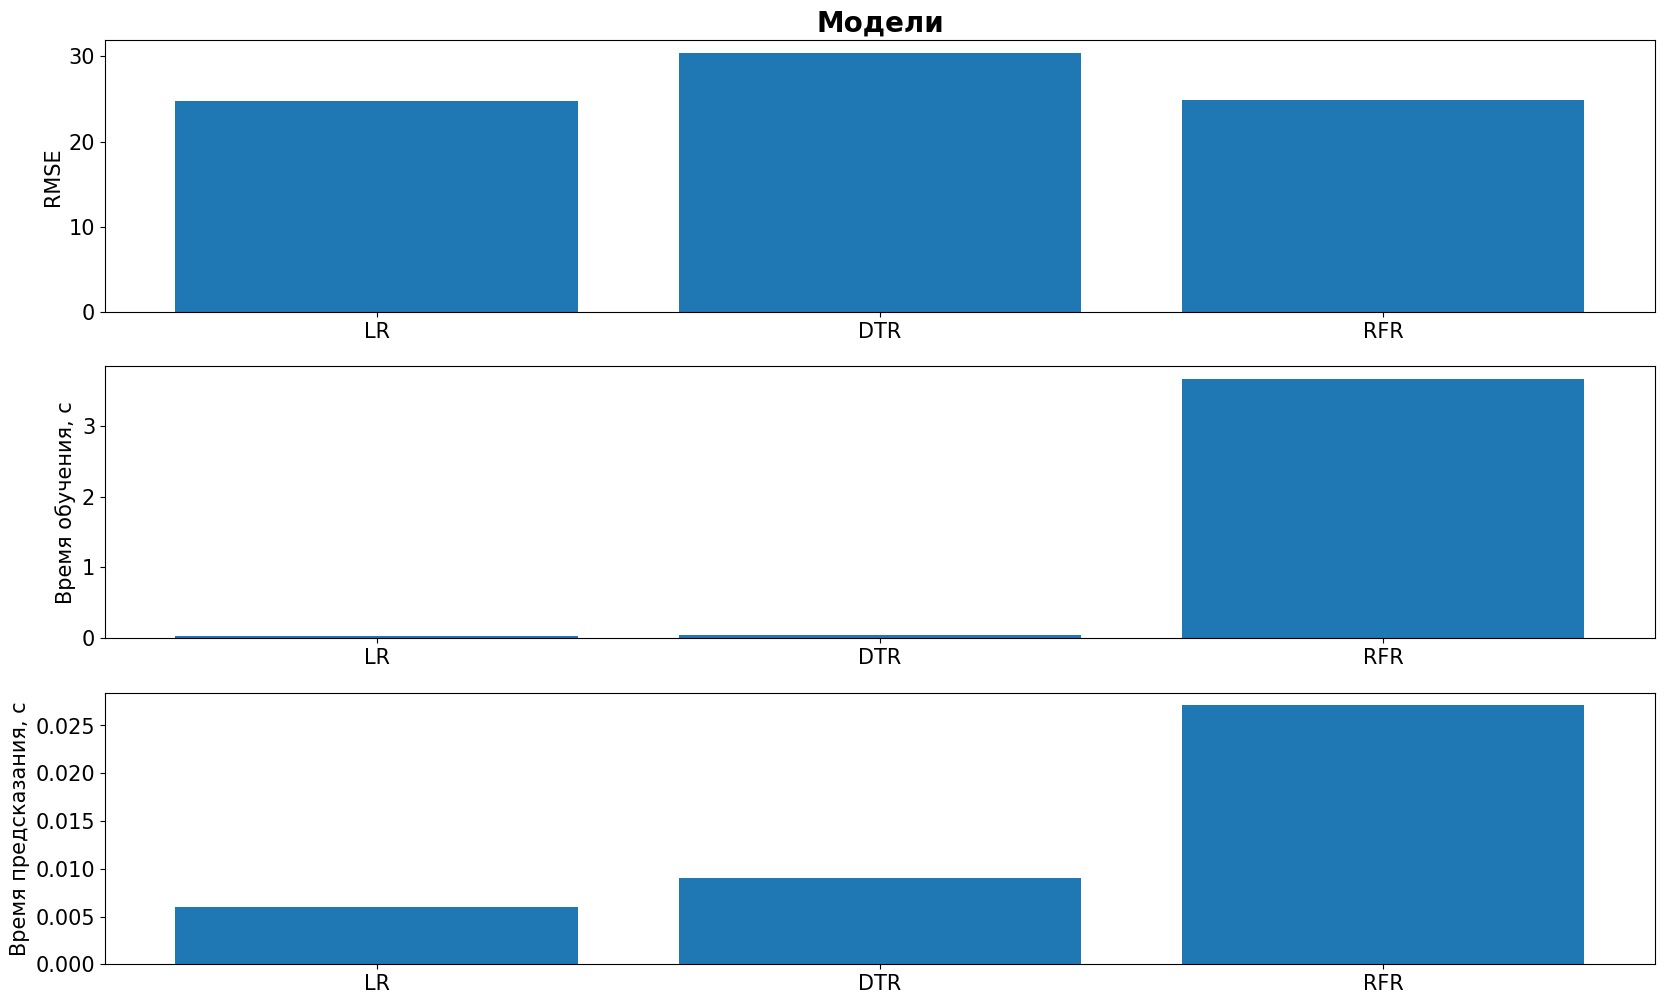

In [22]:
data_for_graph_score = {}
data_for_graph_fitting_time = {}
data_for_graph_prediction_time = {}

for result in results:
    data_for_graph_score[str(result[0])] = result[3]
    data_for_graph_fitting_time[str(result[0])] = result[4]
    data_for_graph_prediction_time[str(result[0])] = result[5]

data_for_graph_score = pd.Series(data_for_graph_score)
data_for_graph_fitting_time = pd.Series(data_for_graph_fitting_time)
data_for_graph_prediction_time = pd.Series(data_for_graph_prediction_time)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
ax1.set_title('Модели', fontsize=20, weight='bold')
ax1.set_ylabel('RMSE', fontsize=15)
ax2.set_ylabel('Время обучения, с', fontsize=15)
ax3.set_ylabel('Время предсказания, с', fontsize=15)
ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax3.tick_params(axis='both', labelsize=15)
ax1.bar(data_for_graph_score.index, data_for_graph_score.values)
ax2.bar(data_for_graph_fitting_time.index, data_for_graph_fitting_time.values)
ax3.bar(data_for_graph_prediction_time.index, data_for_graph_prediction_time.values)
plt.show();

Как видим лучшие результаты из 3 кандидатов показывает обычная линейная регрессия, причем как по точности, так и по времени обучения и прогнозирования.

Проведем выбор лучшей модели по основному параметру (RMSE):

In [23]:
best_model_name = None
best_model = None
best_params = None
best_result = float('inf')

for result in results:
    if result[3] < best_result:
        best_model_name = result[0]
        best_model = result[1]
        best_params = result[2]
        best_result = result[3]

display(f'Лучшая модель: {best_model_name}, {best_params}')
display(f'RMSE лучшей модели: {best_result:0.2f}')

'Лучшая модель: LR, {}'

'RMSE лучшей модели: 24.82'

## Проверка на тестовых данных

In [24]:
pipe = best_model
display(pipe)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

Проверим результаты работы выбранной модели на тестовых данных:

In [25]:
%%time
# Запускаем обучение
pipe.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 23 ms


Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

Сделаем расчёт предсказания:

In [26]:
%%time
y_predicted = pipe.predict(X_test)

CPU times: total: 0 ns
Wall time: 8.01 ms


Посчитаем итоговую оценку:

In [27]:
rmse_score = mean_squared_error(y_test, y_predicted, squared=False)
display(f'Итоговый RMSE: {rmse_score:.2f}')

'Итоговый RMSE: 41.66'

## Выводы

* Загружены и изученные данные компании по количеству поездок такси. Данные относительно чистые, пропусков и дублей нет.
* После почасового ресемплирования количество строк в данных составило 4416 строк.
* Проведен визуальный осмотр данных, заметен тренд на рост количества поездок в период наблюдения. В данных присутствуют объяснимые пики (в основном связанные с периодами отпусков).
* На основе первоначальных данных сгенерирован ряд показателей, которые впоследствии были использованы в качестве выходных параметров для обучения модели. Среди них информация о дне недели, дне месяца, месяце, скользящем среднем (недельном), тренде, сезонной составляющей, остатке, лагах (вплоть до 24 часов).
* На основе этих данных были протестированы 3 регрессионных модели (LR, DTR, RFR). По всем показателям (точность, время обучения и время предсказания) лучшие результаты показала модель обычной линейной регрессии.
* **Итоговое тестирование на тестовой подвыборке показало результат по RMSE 41.66, что ниже максимального уровня, необходимого для клиента.**